In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from aide_design import physchem as pc

from aide_design.units import unit_registry as u

from aide_design import utility as ut


<div class="alert alert-block alert-info">

# You should not use a single for loop in this design challenge.

Numpy, fortunately, understands how to do matrix/array operations index by index. So if you have two length 5 arrays that you want to multiply index by index, you can simply multiply them! This will remove many errors that the TAs have been seeing in code, and allow you to focus more on the rest of the code rather than frustrating indexing errors. 

`array3 = array1*array2`

This is more elegant and easier to troubleshoot than:

`array3 = np.empty_like(array1)
for i in range (0,len(array1)):
    array3[i] = array1[i]*array2[i]`

<br>    
Numpy can handle addition, subtraction, multiplication, and division between arrays.

# DC Rapid Mix

This design challenge contains two parts:
- In the first section, we will explore the energy requirements and operating costs for conventional mechanized rapid mix. This provides an opportunity to learn about the consequences of failing to design for sustainability. Rapid mix is both poorly understood and potentially very important in determining the successful operation of a water treatment plant.
- In the second section, we will explore the energy dissipation rate in a free jet. 

# Part 1: Temperature effects, energy use, and operating costs

### 1)
Create a graph of the kinematic viscosity of water as a function of temperature. Use the `pc.viscosity_kinematic` function. 
1.  Create an array of temperatures (0 to 35) using `np.linspace` to create a dimensionless array. Then, attach appropriate temperature dimensions to the array using the `u.Quantity` function. You can do this in one line!
1. Pass the entire array of temperatures to the kinematic viscosity function in aide_design.physchem to obtain an array of corresponding viscosities.
1. Plot viscosity (mm^2/s) as a function of temperature (Celcius).

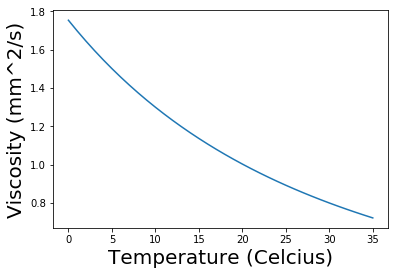

In [2]:
# Create an array of temperature
Temp = u.Quantity(np.linspace(0,35,36),u.degC)

# Obtain an array of corresponding viscosities
Vis = pc.viscosity_kinematic (Temp)

# create plot
plt.plot(Temp,Vis.to(u.mm*u.mm/u.s),'-')
plt.xlabel('Temperature (Celcius)', fontsize=20)
plt.ylabel('Viscosity (mm^2/s)', fontsize=20)
plt.show()


We will design a mechanized rapid mix unit and then analyze the energy costs of mixing for a conventional water treatment plant. Below is a table of conventional design parameters. Note: Double click on this cell to see how this table is formatted. Isn't it cool how Jupyter recognizes this and formats it so nicely? Run this cell to turn it back into a nicely formatted markdown cell.

| Residence Time (s) | Velocity Gradient (G)  (1/s) | Equivalent Height (m) |
|:------------------:|:----------------------------:|:---------------------:|
|         0.5        |             4000             |          0.8          |
|       10 - 20      |             1500             |       2.3 - 4.6       |
|       20 - 30      |              950             |       1.8 - 2.8       |
|       30 - 40      |              850             |       2.2 - 2.9       |
|      40 - 130      |              750             |       2.3 - 7.5       |

### 2)
**Define a function** for the power required to run a rapid mix unit. The rapid mix shaft power function should have flow, velocity gradient, residence time (which can be described with t or $\theta$, as in the equation below), and temperature as its only inputs.

$ P = G^2Q\theta \nu \rho $

Using your function, plot the shaft power (kW) required for a conventional rapid mix unit that has a residence time of t = 15s, a velocity gradient of G = 1500/s, and a flow rate of 50 L/s as a function of temperature (Celcius).


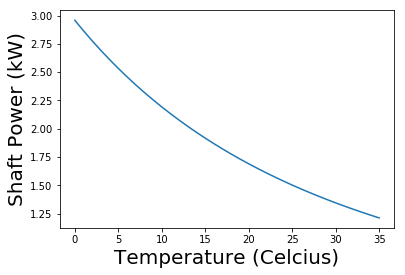

In [3]:
def Req_Power(Flow,Velocity_Gra,Resi_Time,Temp):
    # Return the power required to run a rapid mix unit
    Vis = pc.viscosity_kinematic(Temp)
    Den = pc.density_water(Temp)
    Power_Req = Velocity_Gra*Velocity_Gra*Flow*Resi_Time*Vis*Den
    return (Power_Req)

# Assign all the knowns to variables
t = 15 *u.s
Velocity_Gra = 1500/u.s
Flow = 50 * u.L/u.s
Power = Req_Power(Flow,Velocity_Gra,t,Temp)

# create plot
plt.plot(Temp,Power.to(u.kW),'-')
plt.xlabel('Temperature (Celcius)', fontsize=20)
plt.ylabel('Shaft Power (kW)', fontsize=20)
plt.show()

### 3)
How would the shaft power for a conventional design be selected? You must consider the fact that temperature changes throughout the year, and temperature impacts the shaft power requirements as defined in your function above. Presumably, you should use the lowest water temperature that you expect to have to treat to make your design because low temperatures require the highest shaft power input (as shown in your graph above) and we want to design for the most conservative option.

Imagine you are designing a rapid mix unit for a water treatment plant in upstate NY. Water freezes in the winter, so the power requirements to run a rapid mix must be based on TempDesign = 0 °C. 

What is the required shaft power **in horsepower** for your water treatment plant in upsstate NY? Calculate the shaft power using the design temperature, and take other necessary parameters from Problem 2.

You can [find pint's unit registry here.](https://github.com/hgrecco/pint/blob/c5925bfdab09c75a26bb70cd29fb3d34eed56a5f/pint/default_en_0.6.txt). We recommend bookmarking this page!

In [4]:
Lowest_Temp = u.Quantity(0,u.degC)
Highest_Power = Req_Power(Flow,Velocity_Gra,t,Lowest_Temp).to(u.hp)
print('The required shaft power is '  + ut.sig(Highest_Power,5)+ ' for the water\
 treatment plant in upstate NY.')


The required shaft power is 3.9671 hp for the water treatment plant in upstate NY.


### 4)
What is the equivalent height in meters that this much shaft power could elevate the water in a pump, assuming the pump is 100% efficient? Dimensional analysis of units is useful for this question. How do you get from units of power to units of length, and what constants will get you there?

You may assume 100% efficiency in conversion of shaft power to increased potential energy. For comparison, the difference in water level between the entrance tank and flocculator for an AguaClara plant is less than 40 cm, and 20 cm of that elevation drop is used for flow measurement in the LFOM.

In [5]:
# One constant we need to know to convert from units of power to units of length is 
# the density of water and also the gravity
# We want to frist convert the volumetric flow rate to mass flow rate
Mass_Flow = (Flow * pc.density_water(Lowest_Temp)).to(u.kg/u.s)
Eq_Height = (Highest_Power / Mass_Flow / pc.gravity) . to(u.m)
print('The equivalent height that this much shaft power could elevate the water\
 in a pump is '  + ut.sig(Eq_Height,3)+ '.')



The equivalent height that this much shaft power could elevate the water in a pump is 6.03 m.


### 5a)
Our next task is to select a motor that can provide the required shaft power, as calculated in Problem 3. 

* First, bring in the `motor_efficiency.xlsx` file provided for this design challenge. You imported a similar file in Problem 13 of DC Python Tutorial 2, but this time you will use `pd.read_excel(filename.xlsx)` since the file is .xlsx instead of .csv.
* Display the extracted excel data, `motor_efficiency.xlsx`.
* Extract the column of available horsepower and the column of premium efficiencies from the excel file and place them within their own 1D numpy arrays. 
* Apply appropriate units to the two extracted numpy arrays. 

**NOTE:** The variable to which you assign the extracted excel document is a special type of data structure called a [dataframe](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe). You can call a column of data from a dataframe by 'indexing' by the columns title in the original file, like `dataframe['Horsepower']`. Make sure the column header is input as a string!

In [6]:
# Read and display the data file
import pandas as pd
import numpy as np
df= pd.read_excel('motor_efficiency.xlsx')
Horsepower =df['Horsepower'].astype(float).values*u.hp
Premium_Efficiency= df['Premium Efficiency'].astype(float).values

### 5b)
It is common in engineering design to have target design value that must be rounded up to the next available manufactured value. In the Flow Control and Measurement Design Challenge, we used this method to take a minimum pipe size required to deliver a target flow rate and then we rounded up to the nearest commonly available pipe size. We wrote a function, `ceil_nearest` in aide_design.utility, that we used to select pipe sizes. Use that function to find a motor that is large enough to drive the rapid mix impeller ([What's an impeller?](https://en.wikipedia.org/wiki/Impeller#In_pumps)).

`ut.ceil_nearest` takes two inputs: the first is the value you are looking to match/exceed. In the pipe sizing example, this would be the smallest pipe that can handle the required flow. The second input is the array through which you are looking to compare the first input. If we continue with the pipe size example, this would be the array of available pipe sizes.

In [7]:
import numpy as np
from astropy import units as u
motor = ut.ceil_nearest (Highest_Power,Horsepower)
print('So '+"{0}".format(motor)+' '+'is the smallest motor that is large enough to drive the rapid mix impeller.')

So 5.0 horsepower is the smallest motor that is large enough to drive the rapid mix impeller.


### 6a)
Our next goal is to find the efficiency of this motor. 

One way to do this is to find the index (row number) of this motor horsepower in the original dataframe (or in your created array) and then use that index to find its corresponding efficiency. Use the `np.where` function to find the index of the motor horsepower. The `where` function will return an array, so you will need to use indexes on the returned array to extract the index of the motor. If you display the returned results, it will help you figure out how to use indexes to get the desired element.

The input in `np.where(input)` is 'number you're looking to match == array you're looking to match it to'. Example: `np.where(variable == array)`

<div class="alert alert-block alert-info">
It is likely you will get the following output:
`(array([8], dtype=int64),)`

How to make sense of this? The parentheses around the entire output specify an array (note the comma before the final parentheses, specifying a blank second index). So you can index with square brackets to call the value within the array (Perhaps try index 0?). You should then get another array. How do you extract the value within this new array?


In [8]:
# Find the index of this motor in Horsepower array
MotorIndex = np.where(motor == Horsepower)[0]

### 6b)
You will now use the index of the motor horsepower that you just found to extract the efficiency of the motor. This can be done by calling the index on the array of efficiencies you created or by calling on data from the original dataframe. Dataframes have a method called [get_value](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.get_value.html) that can return an element in a dataframe given a row index and a column heading. This is done for you as an example. 

For this problem, **extract the efficiency of the motor by calling the index on the array you created in Problem 5a. Return the motor efficiency as a fraction rather than as a percent**.

Note: it would have been much easier to simply define a variable and type in the efficiency. However, if we did that, it would have broken dependency; the notebook wouldn't update correctly when you change the flow rate. Our goal is to create designs that scale correctly when the flow rate is changed. 

In [9]:
#Examplefor how to use .get_value to return an element by calling on row index and column heading

#In this case MotorEfficiencydf is the dataframe created by bringing in the excel data, and MotorIndex is what was found
#in Problem 6a. Change these variables below to whatever you named them above.
MotorEfficiency = Premium_Efficiency[MotorIndex]

#-------------------------------------------Your code below-------------------------------------
print('So the premium efficiency of this motor is '+"{0}".format(MotorEfficiency)+' %.')

So the premium efficiency of this motor is [ 89.6] %.


You might think that the rapid mix unit will take less electrical power when the water is warmer. But that isn't the case because the Reynolds number for the rapid mix propeller is quite high and thus the drag coefficient is independent of Re. This means that the torque required to spin the propeller doesn't change as the viscosity of the water changes. It would be possible to run the propeller slower when the water is warmer because the required energy dissipation rate is lower, but that would require a variable speed drive. You could add a variable speed motor controller to take advantage of this. However, the bigger problem is that we don't yet have a good model explaining what rapid mix does.

### 7)
Now, we want to find a 3 phase, 1800 rpm (approximately!) electric motor that is totally enclosed and fan cooled (TEFC), and that has enough power to operate your rapid mixer at [McMaster Carr](https://www.mcmaster.com/). You can find the link to the CAD drawing if you pretend you are going to select the motor for purchase. This part of the design challenge breaks dependency.

Once you find a sufficient motor, **display the CAD drawing of the motor and create a hyperlink to the motor specifications**. 

Notes: we don't currently know how to select and link to the correct motor using python, which is why you need to go to the McMaster Carr website to find the correct motor. If you know of an easy way to do this, please let us know!

### Insert your hyperlink and CAD drawing in this cell


https://www.mcmaster.com/#5990k314/=19jed63


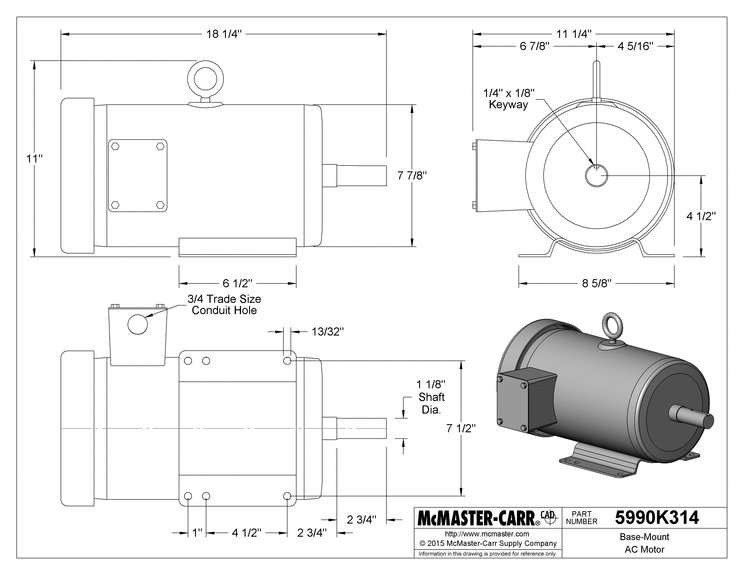




### 8)
How much does the motor cost? Create a variable showing the cost of the motor in USD. We have added USD to pint, so you will not find it in the original registry linked in Problem 3. The abbreviation for US Dollars is `u.USD`.

In [10]:
cost = 714.64 * u.USD
print(cost)

AttributeError: module 'astropy.units' has no attribute 'USD'

### 9)
Now, we want to determine the cost of electricity to operate the rapid mix unit you sized for your water treatment plant in NY.


### 9a)
Find the commercial rate for electricity in NY state at the [U.S. Energy Administration Website](https://www.eia.gov/electricity/data/browser/#/topic/7?agg=0,1&geo=0002&endsec=vg&linechart=ELEC.PRICE.NY-ALL.M~ELEC.PRICE.NY-RES.M~ELEC.PRICE.NY-COM.M~ELEC.PRICE.NY-IND.M~ELEC.PRICE.NY-TRA.M&columnchart=ELEC.PRICE.NY-ALL.M&map=ELEC.PRICE.NY-ALL.M&freq=M&start=200101&end=201706&chartindexed=0&ctype=linechart&ltype=pin&rtype=s&maptype=0&rse=0&pin=). 
Download the data file for NY and then import the data file using pandas (`read_csv`). There are two versions of the csv data file on this page. The one you should use in this problem is titled `Average_retail_price_of_electricity_monthly.csv`. 

For this step, simply **display the resulting data table showing the most recent 12 months of electricity costs in NY**.

Note that this data file has meta information about the data in the first rows. You can [delete those rows by setting header = 4](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) in the function call to the `pd.read_csv`. You can read exactly one year of data by setting nrows = 12. This will make it easy to calculate the average cost for the past year. 



### 9b)
Calculate the average commerial electricity cost for the most recent 12 months. Include the appropriate units. Don't forget to correct for the fact that the prices are given in cents and not dollars.

### 9c)
I think that we should buy electricity in giga Joules. KiloWatt-hr is what you get when someone who loves English units decides they don't like seconds as the base unit of time that is the standard in the metric system. 

How much would a giga Joule cost for the most recent 12 months? All you have to do is change the displayed units!

Look through the pint unit registry. To add orders of magnitude (like kilo, micro, giga, yotta), simply place the appropriate prefix before the usual unit abbreviation. A yotta-meter is `u.Ym`, for example, as '`Y`' represents yotta- in pint.

### 9d)
Let's look back to our design of a rapid mix unit for a water treatment plant in New York. Estimate the electricity demand * **in kilowatts** * for the rapid mix by taking the shaft power required and adjust for the efficiency of the motor that you have selected. Note that when a motor is running it does not necessarily operate at full load and hence at full power. Electric motors maintain their efficiency over a wide range of loads. To calculate the electricity consumption, use the actual shaft power required by the rapid mix and the motor efficiency. Calculate the electrical power required by the motor when the water is at its coldest.

### 9e)
Calculate the annual cost of electricity in dollars required to operate the rapid mix unit.

### 9f)
What is the total cumulative energy costs for the rapid mix unit over a period of 25 years? Note that we are not including the projected increase in electricity costs over the next 25 years. That would be a nice addition to this analysis that would make the need for energy efficiency all the more apparent, but we are ignoring that complexity for this problem.

### 10)
Write a paragraph describing what you learned from this design challenge. Include reflections on the temptation to use a standard design, the low capital cost of energy wasting designs, and the long term implications of engineering that isn't guided by a goal of sustainability.

### Insert Paragraph Here:


# Part 2: Energy dissipation rates in free jets (think flow expansion!)

### 11)
Create a function to return maximum energy dissipation rate along the centerline of a free jet given inputs of distance downstream of the jet (along the centerline), jet velocity, and initial jet diameter. You will find the Rapid Mix powerpoint useful in finding a relationship between these variables.


Use your function to create a graph of the centerline (maximum) energy dissipation rate as a function of distance from jet origin. 
* Use an initial diameter of DiamJet = 10 cm and a velocity of VelJet = 1 m/s. 
* Use a range of 7 to 20 jet diameters when creating the graph. 
* Use units of meters for the x-axis and W/kg for the y-axis. Make sure to label your axes correctly.